# Device-wise Data Analysis for IoT Malware Detection

This notebook performs detailed analysis of individual device data to understand patterns and potential issues affecting model accuracy.

**Goal**: Identify why neural network accuracy is not crossing 90% by analyzing device-specific patterns.

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [13]:
# Define attack types and labels
attack_types = {
    'benign': 0,
    'gafgyt.combo': 1,
    'gafgyt.junk': 2, 
    'gafgyt.tcp': 3,
    'gafgyt.udp': 4,
    'mirai.ack': 5,
    'mirai.scan': 6,
    'mirai.syn': 7,
    'mirai.udp': 8,
    'mirai.udpplain': 9
}

# Devices to analyze (first 5 devices)
devices_to_analyze = [1, 2,4, 5,6,7]
data_path = 'fdata'

print(f"Analyzing devices: {devices_to_analyze}")
print(f"Attack types: {list(attack_types.keys())}")

Analyzing devices: [1, 2, 4, 5, 6, 7]
Attack types: ['benign', 'gafgyt.combo', 'gafgyt.junk', 'gafgyt.tcp', 'gafgyt.udp', 'mirai.ack', 'mirai.scan', 'mirai.syn', 'mirai.udp', 'mirai.udpplain']


In [14]:
# Load device-wise data
def load_device_data(device_id, data_path):
    """Load all data for a specific device"""
    device_data = {}
    
    for attack_type, label in attack_types.items():
        filename = f"{device_id}.{attack_type}.csv"
        filepath = os.path.join(data_path, filename)
        
        if os.path.exists(filepath):
            try:
                df = pd.read_csv(filepath)
                df['attack_type'] = attack_type
                df['label'] = label
                df['device_id'] = device_id
                device_data[attack_type] = df
                print(f"Device {device_id} - {attack_type}: {df.shape[0]} samples")
            except Exception as e:
                print(f"Error loading {filename}: {e}")
        else:
            print(f"File not found: {filename}")
    
    return device_data

# Load data for all devices
all_device_data = {}
for device_id in devices_to_analyze:
    print(f"\n--- Loading Device {device_id} ---")
    all_device_data[device_id] = load_device_data(device_id, data_path)


--- Loading Device 1 ---
Device 1 - benign: 49548 samples
Device 1 - gafgyt.combo: 59718 samples
Device 1 - gafgyt.junk: 29068 samples
Device 1 - gafgyt.tcp: 92141 samples
Device 1 - gafgyt.udp: 105874 samples
Device 1 - mirai.ack: 102195 samples
Device 1 - mirai.scan: 107685 samples
Device 1 - mirai.syn: 122573 samples
Device 1 - mirai.udp: 237665 samples
Device 1 - mirai.udpplain: 81982 samples

--- Loading Device 2 ---
Device 2 - benign: 13113 samples
Device 2 - gafgyt.combo: 53012 samples
Device 2 - gafgyt.junk: 30312 samples
Device 2 - gafgyt.tcp: 95021 samples
Device 2 - gafgyt.udp: 104791 samples
Device 2 - mirai.ack: 113285 samples
Device 2 - mirai.scan: 43192 samples
Device 2 - mirai.syn: 116807 samples
Device 2 - mirai.udp: 151481 samples
Device 2 - mirai.udpplain: 87368 samples

--- Loading Device 4 ---
Device 4 - benign: 175240 samples
Device 4 - gafgyt.combo: 58152 samples
Device 4 - gafgyt.junk: 28349 samples
Device 4 - gafgyt.tcp: 92581 samples
Device 4 - gafgyt.udp: 10

In [15]:
# Data availability analysis
def analyze_data_availability():
    """Analyze which attack types are available for each device"""
    availability_matrix = pd.DataFrame(index=devices_to_analyze, columns=list(attack_types.keys()))
    sample_counts = pd.DataFrame(index=devices_to_analyze, columns=list(attack_types.keys()))
    
    for device_id in devices_to_analyze:
        for attack_type in attack_types.keys():
            if attack_type in all_device_data[device_id]:
                availability_matrix.loc[device_id, attack_type] = 'Available'
                sample_counts.loc[device_id, attack_type] = all_device_data[device_id][attack_type].shape[0]
            else:
                availability_matrix.loc[device_id, attack_type] = 'Missing'
                sample_counts.loc[device_id, attack_type] = 0
    
    return availability_matrix, sample_counts

availability, sample_counts = analyze_data_availability()

print("Data Availability Matrix:")
print(availability)
print("\nSample Counts:")
print(sample_counts)

Data Availability Matrix:
      benign gafgyt.combo gafgyt.junk gafgyt.tcp gafgyt.udp  mirai.ack   
1  Available    Available   Available  Available  Available  Available  \
2  Available    Available   Available  Available  Available  Available   
4  Available    Available   Available  Available  Available  Available   
5  Available    Available   Available  Available  Available  Available   
6  Available    Available   Available  Available  Available  Available   
7  Available    Available   Available  Available  Available    Missing   

  mirai.scan  mirai.syn  mirai.udp mirai.udpplain  
1  Available  Available  Available      Available  
2  Available  Available  Available      Available  
4  Available  Available  Available      Available  
5  Available  Available  Available      Available  
6  Available  Available  Available      Available  
7    Missing    Missing    Missing        Missing  

Sample Counts:
   benign gafgyt.combo gafgyt.junk gafgyt.tcp gafgyt.udp mirai.ack mirai.sc

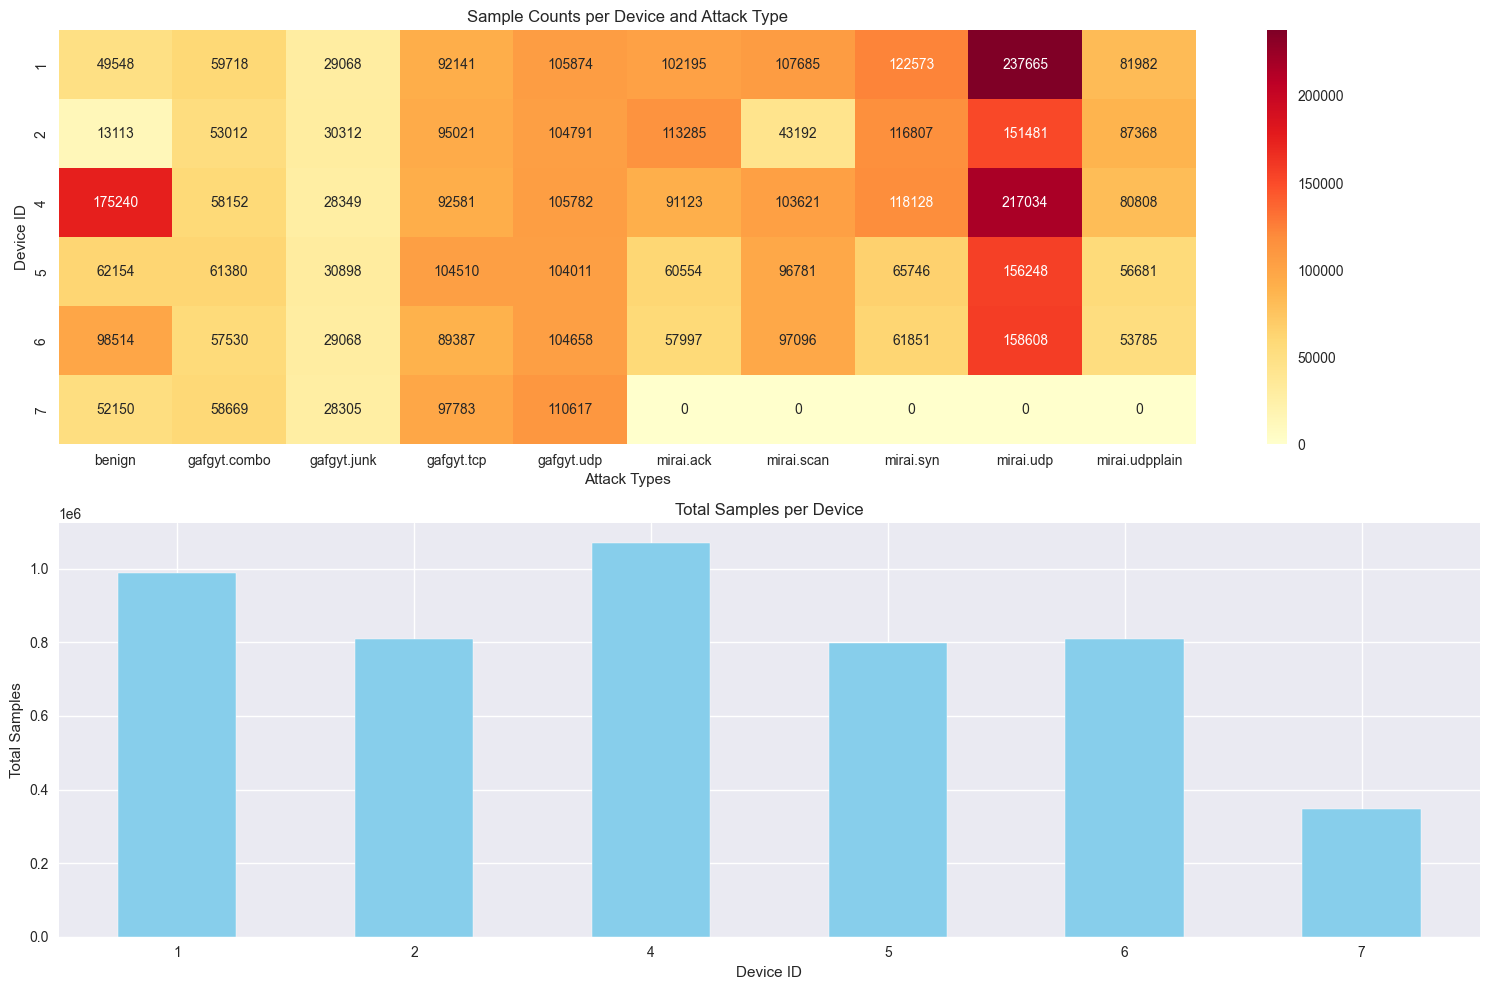


Key Observations:
Device with most data: Device 4 (1,070,818 samples)
Device with least data: Device 7 (347,524 samples)
Average samples per device: 803772


In [16]:
# Visualize data availability and sample distribution
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Convert sample_counts to numeric for plotting
sample_counts_numeric = sample_counts.apply(pd.to_numeric, errors='coerce').fillna(0)

# Plot 1: Heatmap of sample counts
sns.heatmap(sample_counts_numeric, annot=True, fmt='g', cmap='YlOrRd', ax=axes[0])
axes[0].set_title('Sample Counts per Device and Attack Type')
axes[0].set_xlabel('Attack Types')
axes[0].set_ylabel('Device ID')

# Plot 2: Bar plot of total samples per device
total_samples_per_device = sample_counts_numeric.sum(axis=1)
total_samples_per_device.plot(kind='bar', ax=axes[1], color='skyblue')
axes[1].set_title('Total Samples per Device')
axes[1].set_xlabel('Device ID')
axes[1].set_ylabel('Total Samples')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print(f"Device with most data: Device {total_samples_per_device.idxmax()} ({total_samples_per_device.max():,} samples)")
print(f"Device with least data: Device {total_samples_per_device.idxmin()} ({total_samples_per_device.min():,} samples)")
print(f"Average samples per device: {total_samples_per_device.mean():.0f}")

In [17]:
# Feature analysis for each device
def analyze_device_features(device_id):
    """Analyze feature statistics for a specific device"""
    print(f"\n{'='*50}")
    print(f"DEVICE {device_id} FEATURE ANALYSIS")
    print(f"{'='*50}")
    
    device_data = all_device_data[device_id]
    
    # Combine all attack types for this device
    combined_data = []
    for attack_type, df in device_data.items():
        combined_data.append(df)
    
    if combined_data:
        device_df = pd.concat(combined_data, ignore_index=True)
        
        # Remove non-numeric columns for analysis
        numeric_cols = device_df.select_dtypes(include=[np.number]).columns.tolist()
        if 'label' in numeric_cols:
            numeric_cols.remove('label')
        if 'device_id' in numeric_cols:
            numeric_cols.remove('device_id')
            
        print(f"Total samples: {len(device_df):,}")
        print(f"Number of features: {len(numeric_cols)}")
        print(f"Attack type distribution:")
        print(device_df['attack_type'].value_counts())
        
        # Feature statistics
        feature_stats = device_df[numeric_cols].describe()
        
        # Find features with zero variance (constant features)
        zero_var_features = [col for col in numeric_cols if device_df[col].std() == 0]
        
        print(f"\nFeatures with zero variance: {len(zero_var_features)}")
        if zero_var_features:
            print(f"Examples: {zero_var_features[:5]}")
        
        # Find features with very low variance
        low_var_threshold = 0.01
        low_var_features = [col for col in numeric_cols if 0 < device_df[col].std() < low_var_threshold]
        
        print(f"Features with very low variance (< {low_var_threshold}): {len(low_var_features)}")
        
        # Check for missing values
        missing_values = device_df[numeric_cols].isnull().sum().sum()
        print(f"Total missing values: {missing_values}")
        
        return {
            'total_samples': len(device_df),
            'num_features': len(numeric_cols),
            'zero_var_features': len(zero_var_features),
            'low_var_features': len(low_var_features),
            'missing_values': missing_values,
            'attack_distribution': device_df['attack_type'].value_counts().to_dict(),
            'feature_stats': feature_stats
        }
    else:
        print("No data available for this device")
        return None

# Analyze each device
device_analysis_results = {}
for device_id in devices_to_analyze:
    device_analysis_results[device_id] = analyze_device_features(device_id)


DEVICE 1 FEATURE ANALYSIS
Total samples: 988,449
Number of features: 115
Attack type distribution:
attack_type
mirai.udp         237665
mirai.syn         122573
mirai.scan        107685
gafgyt.udp        105874
mirai.ack         102195
gafgyt.tcp         92141
mirai.udpplain     81982
gafgyt.combo       59718
benign             49548
gafgyt.junk        29068
Name: count, dtype: int64

Features with zero variance: 0
Features with very low variance (< 0.01): 7
Total missing values: 0

DEVICE 2 FEATURE ANALYSIS
Total samples: 808,382
Number of features: 115
Attack type distribution:
attack_type
mirai.udp         151481
mirai.syn         116807
mirai.ack         113285
gafgyt.udp        104791
gafgyt.tcp         95021
mirai.udpplain     87368
gafgyt.combo       53012
mirai.scan         43192
gafgyt.junk        30312
benign             13113
Name: count, dtype: int64

Features with zero variance: 0
Features with very low variance (< 0.01): 0
Total missing values: 0

DEVICE 4 FEATURE ANALYS

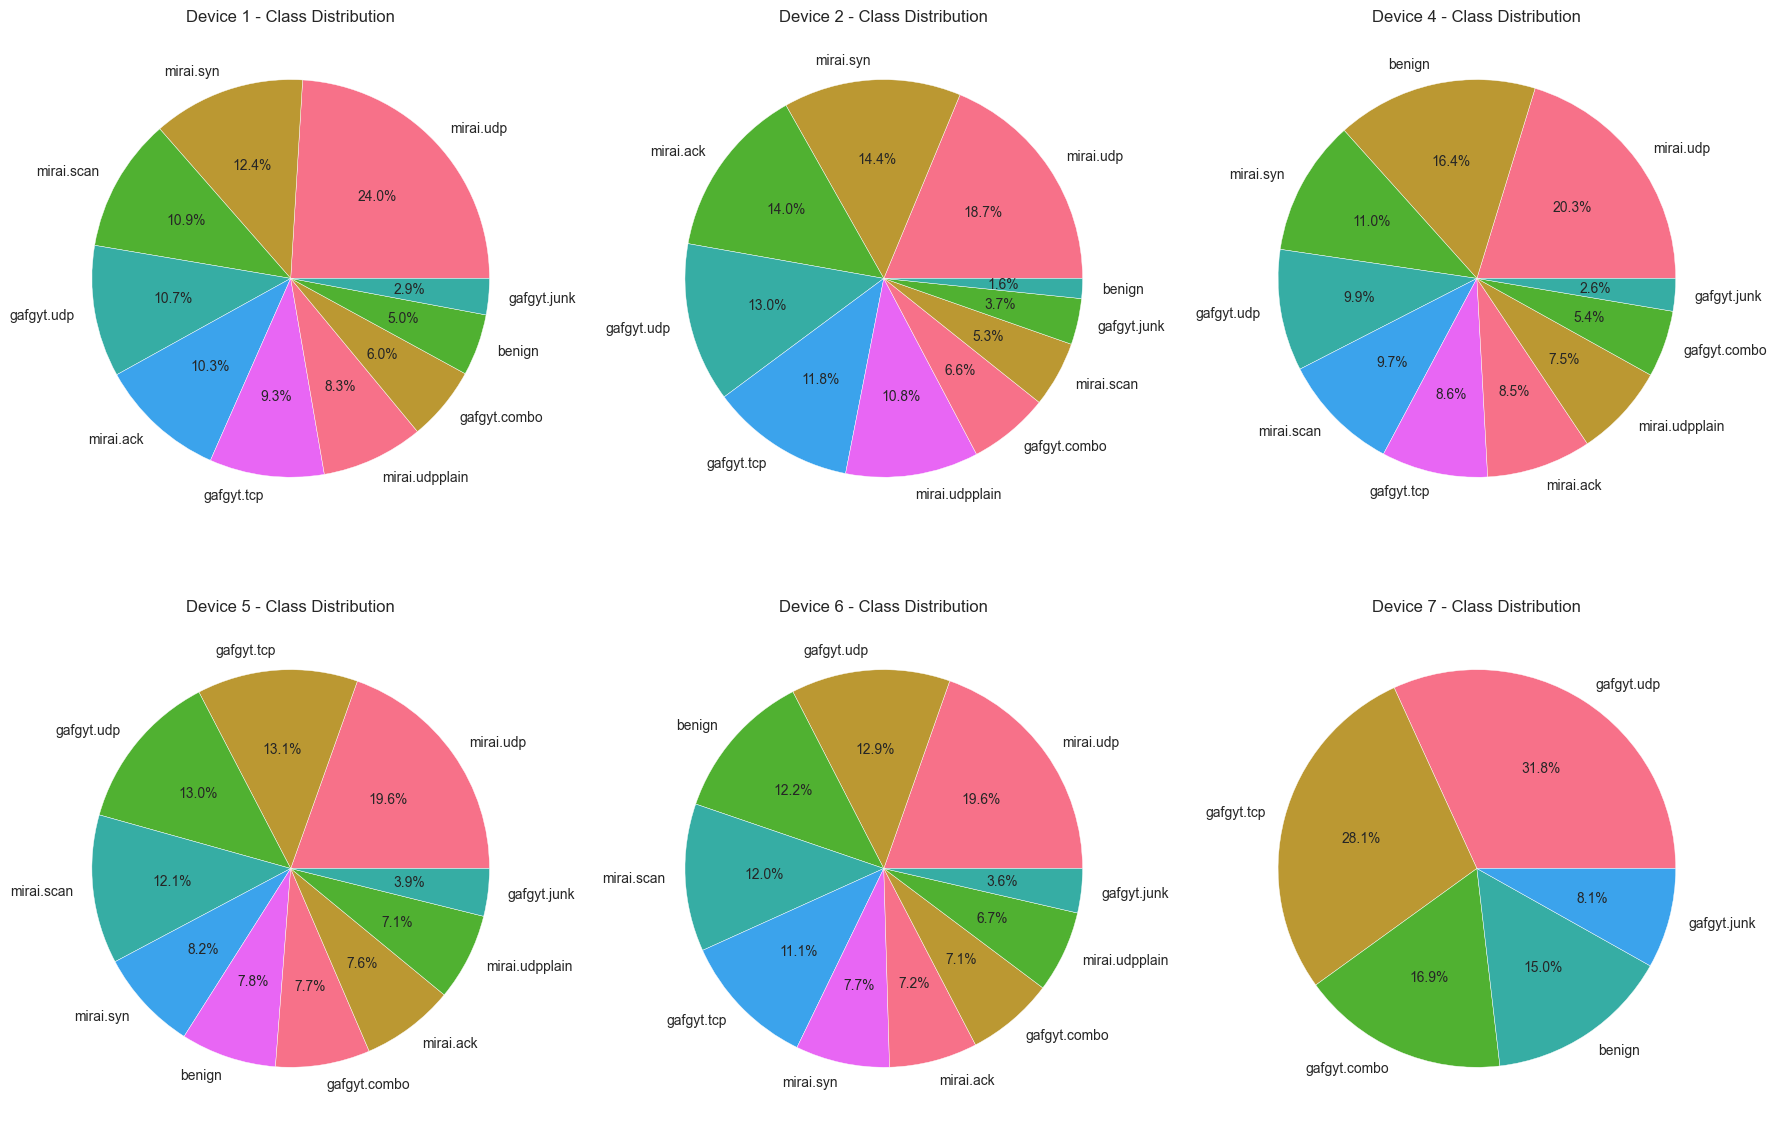

In [18]:
# Class balance analysis
def analyze_class_balance():
    """Analyze class balance across devices"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    class_distributions = []
    
    for i, device_id in enumerate(devices_to_analyze):
        if device_analysis_results[device_id]:
            attack_dist = device_analysis_results[device_id]['attack_distribution']
            
            # Convert to series for plotting
            dist_series = pd.Series(attack_dist)
            class_distributions.append(dist_series)
            
            # Plot pie chart for each device
            dist_series.plot(kind='pie', ax=axes[i], autopct='%1.1f%%')
            axes[i].set_title(f'Device {device_id} - Class Distribution')
            axes[i].set_ylabel('')
        else:
            axes[i].text(0.5, 0.5, f'No data for Device {device_id}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'Device {device_id} - No Data')
    
    # Hide the last subplot if not used
    if len(devices_to_analyze) < len(axes):
        axes[-1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return class_distributions

class_distributions = analyze_class_balance()

Device Comparison Summary:
   Device  Total_Samples  Num_Features  Zero_Var_Features  Low_Var_Features   
0       1         988449           115                  0                 7  \
1       2         808382           115                  0                 0   
2       4        1070818           115                  0                 0   
3       5         798963           115                  0                 0   
4       6         808494           115                  0                 0   
5       7         347524           115                  0                 0   

   Missing_Values  Num_Attack_Types  
0               0                10  
1               0                10  
2               0                10  
3               0                10  
4               0                10  
5               0                 5  


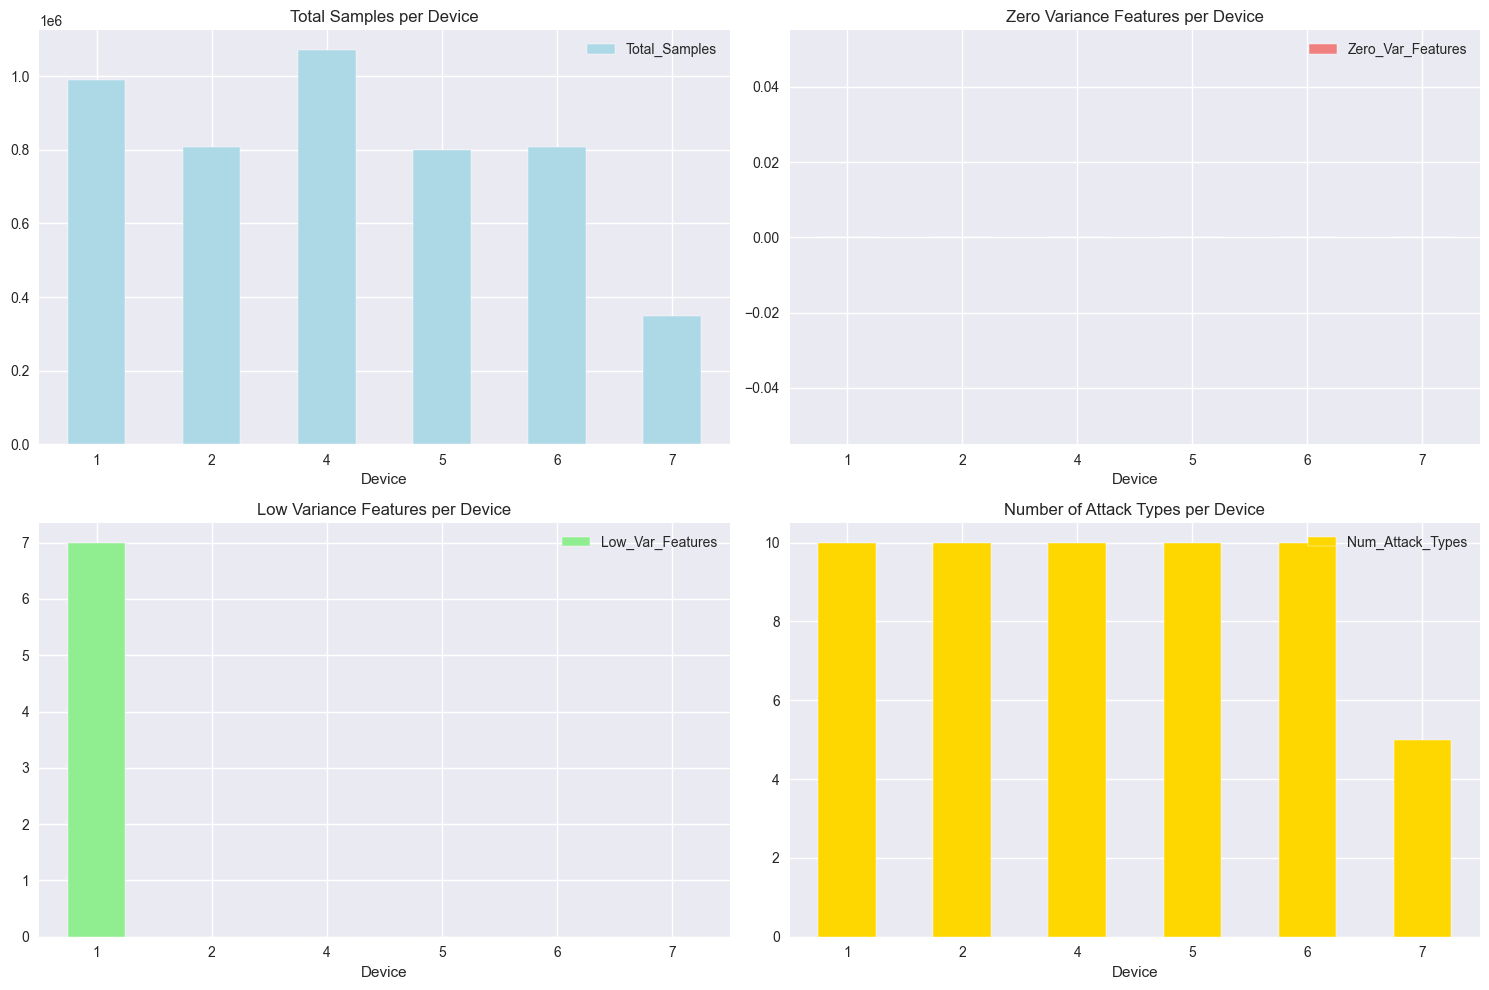

In [19]:
# Statistical comparison between devices
def compare_devices_statistically():
    """Compare key statistics between devices"""
    comparison_data = []
    
    for device_id in devices_to_analyze:
        if device_analysis_results[device_id]:
            result = device_analysis_results[device_id]
            comparison_data.append({
                'Device': device_id,
                'Total_Samples': result['total_samples'],
                'Num_Features': result['num_features'],
                'Zero_Var_Features': result['zero_var_features'],
                'Low_Var_Features': result['low_var_features'],
                'Missing_Values': result['missing_values'],
                'Num_Attack_Types': len(result['attack_distribution'])
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("Device Comparison Summary:")
    print(comparison_df)
    
    # Visualize the comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Total samples comparison
    comparison_df.plot(x='Device', y='Total_Samples', kind='bar', ax=axes[0,0], color='lightblue')
    axes[0,0].set_title('Total Samples per Device')
    axes[0,0].tick_params(axis='x', rotation=0)
    
    # Zero variance features
    comparison_df.plot(x='Device', y='Zero_Var_Features', kind='bar', ax=axes[0,1], color='lightcoral')
    axes[0,1].set_title('Zero Variance Features per Device')
    axes[0,1].tick_params(axis='x', rotation=0)
    
    # Low variance features
    comparison_df.plot(x='Device', y='Low_Var_Features', kind='bar', ax=axes[1,0], color='lightgreen')
    axes[1,0].set_title('Low Variance Features per Device')
    axes[1,0].tick_params(axis='x', rotation=0)
    
    # Number of attack types
    comparison_df.plot(x='Device', y='Num_Attack_Types', kind='bar', ax=axes[1,1], color='gold')
    axes[1,1].set_title('Number of Attack Types per Device')
    axes[1,1].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

device_comparison = compare_devices_statistically()

Inter-Device Feature Correlation Analysis
Common features across all devices: 115


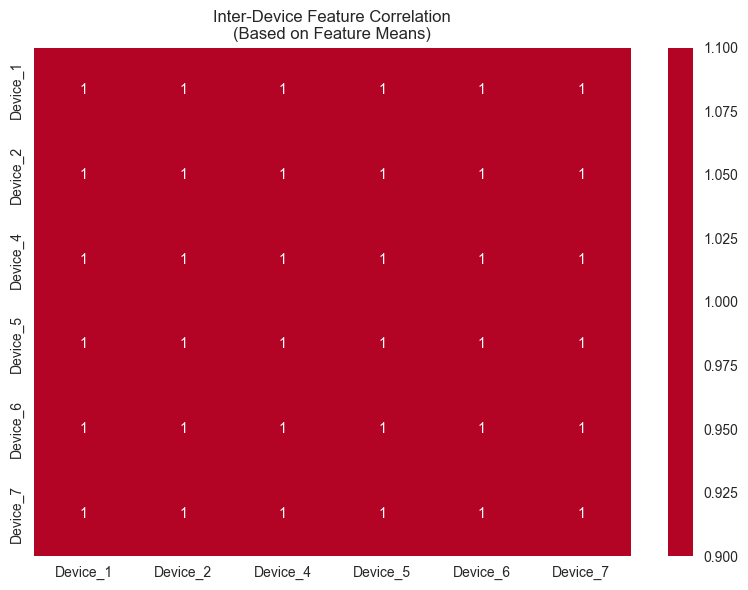


Device Correlation Matrix:
          Device_1  Device_2  Device_4  Device_5  Device_6  Device_7
Device_1       1.0       1.0       1.0       1.0       1.0       1.0
Device_2       1.0       1.0       1.0       1.0       1.0       1.0
Device_4       1.0       1.0       1.0       1.0       1.0       1.0
Device_5       1.0       1.0       1.0       1.0       1.0       1.0
Device_6       1.0       1.0       1.0       1.0       1.0       1.0
Device_7       1.0       1.0       1.0       1.0       1.0       1.0


In [20]:
# Feature correlation analysis between devices
def analyze_inter_device_correlation():
    """Analyze if same features behave similarly across devices"""
    print("Inter-Device Feature Correlation Analysis")
    print("="*50)
    
    # Get common features across all devices
    common_features = None
    device_feature_means = {}
    
    for device_id in devices_to_analyze:
        if device_analysis_results[device_id]:
            device_data = all_device_data[device_id]
            
            # Combine all attack types for this device
            combined_data = []
            for attack_type, df in device_data.items():
                combined_data.append(df)
            
            if combined_data:
                device_df = pd.concat(combined_data, ignore_index=True)
                numeric_cols = device_df.select_dtypes(include=[np.number]).columns.tolist()
                
                # Remove non-feature columns
                feature_cols = [col for col in numeric_cols if col not in ['label', 'device_id']]
                
                if common_features is None:
                    common_features = set(feature_cols)
                else:
                    common_features = common_features.intersection(set(feature_cols))
                
                # Calculate feature means for this device
                device_feature_means[device_id] = device_df[feature_cols].mean()
    
    print(f"Common features across all devices: {len(common_features)}")
    
    if len(common_features) > 0 and len(device_feature_means) > 1:
        # Create correlation matrix of feature means across devices
        common_features_list = list(common_features)[:50]  # Limit to first 50 for visualization
        
        means_df = pd.DataFrame()
        for device_id, means in device_feature_means.items():
            means_df[f'Device_{device_id}'] = means[common_features_list]
        
        # Calculate correlation between devices
        device_correlation = means_df.corr()
        
        # Plot correlation heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(device_correlation, annot=True, cmap='coolwarm', center=0)
        plt.title('Inter-Device Feature Correlation\n(Based on Feature Means)')
        plt.tight_layout()
        plt.show()
        
        print("\nDevice Correlation Matrix:")
        print(device_correlation)
        
        return device_correlation
    else:
        print("Insufficient data for correlation analysis")
        return None

device_correlation = analyze_inter_device_correlation()

In [21]:
# Key findings and recommendations
def generate_insights_and_recommendations():
    """Generate key insights and recommendations based on the analysis"""
    print("\n" + "="*70)
    print("KEY INSIGHTS AND RECOMMENDATIONS")
    print("="*70)
    
    insights = []
    recommendations = []
    
    # Data availability insights
    total_samples = [device_analysis_results[d]['total_samples'] for d in devices_to_analyze if device_analysis_results[d]]
    if total_samples:
        max_samples = max(total_samples)
        min_samples = min(total_samples)
        sample_ratio = max_samples / min_samples if min_samples > 0 else float('inf')
        
        if sample_ratio > 5:
            insights.append(f"⚠️  SEVERE DATA IMBALANCE: Sample ratio between devices is {sample_ratio:.1f}:1")
            recommendations.append("🔧 Use stratified sampling or data augmentation for smaller devices")
    
    # Feature quality insights
    zero_var_counts = [device_analysis_results[d]['zero_var_features'] for d in devices_to_analyze if device_analysis_results[d]]
    if zero_var_counts and any(count > 10 for count in zero_var_counts):
        insights.append(f"⚠️  HIGH ZERO-VARIANCE FEATURES: Some devices have {max(zero_var_counts)} constant features")
        recommendations.append("🔧 Remove zero-variance features before training")
    
    # Class balance insights
    for i, device_id in enumerate(devices_to_analyze):
        if device_analysis_results[device_id]:
            attack_dist = device_analysis_results[device_id]['attack_distribution']
            if len(attack_dist) > 1:
                max_class = max(attack_dist.values())
                min_class = min(attack_dist.values())
                imbalance_ratio = max_class / min_class if min_class > 0 else float('inf')
                
                if imbalance_ratio > 10:
                    insights.append(f"⚠️  DEVICE {device_id}: Severe class imbalance ({imbalance_ratio:.1f}:1)")
    
    if any('class imbalance' in insight.lower() for insight in insights):
        recommendations.append("🔧 Use class weighting or SMOTE for balancing classes")
    
    # Device correlation insights
    if device_correlation is not None:
        # Check if devices are very different
        off_diagonal_corr = device_correlation.values[np.triu_indices_from(device_correlation.values, k=1)]
        avg_correlation = np.mean(off_diagonal_corr)
        
        if avg_correlation < 0.5:
            insights.append(f"⚠️  LOW INTER-DEVICE CORRELATION: Avg correlation = {avg_correlation:.3f}")
            recommendations.append("🔧 Consider device-specific models or domain adaptation techniques")
    
    # Missing attack types
    missing_attacks = defaultdict(list)
    for device_id in devices_to_analyze:
        available_attacks = set(all_device_data[device_id].keys())
        missing = set(attack_types.keys()) - available_attacks
        if missing:
            missing_attacks[device_id] = list(missing)
    
    if missing_attacks:
        insights.append("⚠️  MISSING ATTACK TYPES: Some devices don't have all attack types")
        recommendations.append("🔧 Use cross-device data sharing or synthetic data generation")
    
    # Print insights
    print("\n📊 KEY INSIGHTS:")
    for i, insight in enumerate(insights, 1):
        print(f"{i}. {insight}")
    
    print("\n💡 RECOMMENDATIONS FOR IMPROVING 90%+ ACCURACY:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    
    # Additional general recommendations
    print("\n🎯 ADDITIONAL STRATEGIES:")
    print("1. 🔧 Use ensemble methods combining device-specific models")
    print("2. 🔧 Apply feature selection techniques (mutual information, LASSO)")
    print("3. 🔧 Try different architectures (CNN, LSTM, Transformer)")
    print("4. 🔧 Use transfer learning from devices with more data")
    print("5. 🔧 Implement federated learning for privacy-preserving training")
    
    return insights, recommendations

insights, recommendations = generate_insights_and_recommendations()


KEY INSIGHTS AND RECOMMENDATIONS

📊 KEY INSIGHTS:
1. ⚠️  DEVICE 2: Severe class imbalance (11.6:1)
2. ⚠️  MISSING ATTACK TYPES: Some devices don't have all attack types

💡 RECOMMENDATIONS FOR IMPROVING 90%+ ACCURACY:
1. 🔧 Use class weighting or SMOTE for balancing classes
2. 🔧 Use cross-device data sharing or synthetic data generation

🎯 ADDITIONAL STRATEGIES:
1. 🔧 Use ensemble methods combining device-specific models
2. 🔧 Apply feature selection techniques (mutual information, LASSO)
3. 🔧 Try different architectures (CNN, LSTM, Transformer)
4. 🔧 Use transfer learning from devices with more data
5. 🔧 Implement federated learning for privacy-preserving training


In [22]:
# Summary statistics table
def create_summary_table():
    """Create a comprehensive summary table"""
    summary_data = []
    
    for device_id in devices_to_analyze:
        if device_analysis_results[device_id]:
            result = device_analysis_results[device_id]
            attack_dist = result['attack_distribution']
            
            # Calculate class imbalance ratio
            if len(attack_dist) > 1:
                max_class = max(attack_dist.values())
                min_class = min(attack_dist.values())
                imbalance_ratio = max_class / min_class if min_class > 0 else float('inf')
            else:
                imbalance_ratio = 1.0
            
            summary_data.append({
                'Device': device_id,
                'Total_Samples': f"{result['total_samples']:,}",
                'Attack_Types': len(attack_dist),
                'Features': result['num_features'],
                'Zero_Var_Features': result['zero_var_features'],
                'Class_Imbalance_Ratio': f"{imbalance_ratio:.1f}:1",
                'Data_Quality': 'Good' if result['zero_var_features'] < 10 and imbalance_ratio < 5 else 'Poor'
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    print("\n📋 DEVICE SUMMARY TABLE:")
    print("="*80)
    print(summary_df.to_string(index=False))
    
    return summary_df

summary_table = create_summary_table()

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print("\n💡 Next Steps:")
print("1. Implement the recommended preprocessing steps")
print("2. Try device-specific models or federated learning")
print("3. Apply advanced feature selection techniques")
print("4. Use ensemble methods to combine predictions")
print("\n🎯 Goal: Achieve 90%+ accuracy with these optimizations!")


📋 DEVICE SUMMARY TABLE:
 Device Total_Samples  Attack_Types  Features  Zero_Var_Features Class_Imbalance_Ratio Data_Quality
      1       988,449            10       115                  0                 8.2:1         Poor
      2       808,382            10       115                  0                11.6:1         Poor
      4     1,070,818            10       115                  0                 7.7:1         Poor
      5       798,963            10       115                  0                 5.1:1         Poor
      6       808,494            10       115                  0                 5.5:1         Poor
      7       347,524             5       115                  0                 3.9:1         Good

ANALYSIS COMPLETE!

💡 Next Steps:
1. Implement the recommended preprocessing steps
2. Try device-specific models or federated learning
3. Apply advanced feature selection techniques
4. Use ensemble methods to combine predictions

🎯 Goal: Achieve 90%+ accuracy with these opt

In [24]:
# Feature Importance Analysis - Top 30 Features per Device (Decision Tree + Variance)
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd

def analyze_top_features_per_device(device_id, n_features=30, max_samples_per_file=12000):
    """Analyze and extract top N features for a specific device using Decision Tree and Variance methods"""
    print(f"\n{'='*60}")
    print(f"TOP {n_features} FEATURE ANALYSIS - DEVICE {device_id}")
    print(f"Using max {max_samples_per_file:,} samples per file")
    print(f"{'='*60}")
    
    device_data = all_device_data[device_id]
    
    # Combine all attack types for this device with sampling limit
    combined_data = []
    total_original_samples = 0
    total_sampled_samples = 0
    
    for attack_type, df in device_data.items():
        original_samples = len(df)
        total_original_samples += original_samples
        
        # Sample max 12K from each file
        if len(df) > max_samples_per_file:
            sampled_df = df.sample(n=max_samples_per_file, random_state=42)
            print(f"  {attack_type}: {original_samples:,} → {max_samples_per_file:,} samples (sampled)")
        else:
            sampled_df = df.copy()
            print(f"  {attack_type}: {original_samples:,} samples (all used)")
        
        total_sampled_samples += len(sampled_df)
        combined_data.append(sampled_df)
    
    if not combined_data:
        print(f"No data available for device {device_id}")
        return None
    
    device_df = pd.concat(combined_data, ignore_index=True)
    print(f"\nTotal samples: {total_original_samples:,} → {total_sampled_samples:,}")
    
    # Prepare features and labels
    numeric_cols = device_df.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [col for col in numeric_cols if col not in ['label', 'device_id']]
    
    X = device_df[feature_cols]
    y = device_df['label']
    
    # Remove constant features (zero variance)
    non_constant_features = [col for col in feature_cols if X[col].std() > 0]
    X_filtered = X[non_constant_features]
    
    print(f"Original features: {len(feature_cols)}")
    print(f"Non-constant features: {len(non_constant_features)}")
    print(f"Classes: {sorted(y.unique())}")
    print(f"Class distribution: {dict(y.value_counts().sort_index())}")
    
    # Method 1: Decision Tree Feature Importance
    print(f"\n🌳 Decision Tree Feature Importance:")
    try:
        dt = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=20)
        dt.fit(X_filtered, y)
        
        dt_importance = pd.DataFrame({
            'feature': non_constant_features,
            'importance': dt.feature_importances_
        }).sort_values('importance', ascending=False)
        
        top_dt_features = dt_importance.head(n_features)
        print(f"Top {n_features} features by Decision Tree:")
        for i, (_, row) in enumerate(top_dt_features.iterrows(), 1):
            print(f"{i:2d}. {row['feature']:<30} ({row['importance']:.4f})")
            
    except Exception as e:
        print(f"Decision Tree analysis failed: {e}")
        top_dt_features = pd.DataFrame()
    
    
    # Method 2: Variance-based feature selection
    print(f"\n📊 High Variance Features:")
    try:
        feature_variance = pd.DataFrame({
            'feature': non_constant_features,
            'variance': [X_filtered[col].var() for col in non_constant_features]
        }).sort_values('variance', ascending=False)
        
        top_var_features = feature_variance.head(n_features)
        print(f"Top {n_features} features by Variance:")
        for i, (_, row) in enumerate(top_var_features.iterrows(), 1):
            print(f"{i:2d}. {row['feature']:<30} ({row['variance']:.4f})")
            
    except Exception as e:
        print(f"Variance analysis failed: {e}")
        top_var_features = pd.DataFrame()
    
    # Combine Decision Tree and Variance rankings
    print(f"\n🏆 COMBINED RANKING (Decision Tree 70% + Variance 30%):")
    
    all_features = set(non_constant_features)
    combined_scores = {}
    
    for feature in all_features:
        score = 0
        count = 0
        
        # Add Decision Tree score (weight: 0.7)
        if not top_dt_features.empty and feature in top_dt_features['feature'].values:
            dt_mask = top_dt_features['feature'] == feature
            dt_score = top_dt_features[dt_mask]['importance'].iloc[0]
            score += dt_score * 0.7
            count += 0.7
        
        # Add Variance score (weight: 0.3)
        if not top_var_features.empty and feature in top_var_features['feature'].values:
            var_mask = top_var_features['feature'] == feature
            var_score = top_var_features[var_mask]['variance'].iloc[0]
            # Normalize variance score
            max_var = top_var_features['variance'].max()
            normalized_var = var_score / max_var if max_var > 0 else 0
            score += normalized_var * 0.3
            count += 0.3
        
        combined_scores[feature] = score / count if count > 0 else 0
    
    # Sort by combined score
    final_ranking = pd.DataFrame(list(combined_scores.items()), 
                                columns=['feature', 'combined_score']).sort_values('combined_score', ascending=False)
    
    top_final_features = final_ranking.head(n_features)
    
    print(f"Final Top {n_features} Features (Decision Tree + Variance):")
    for i, (_, row) in enumerate(top_final_features.iterrows(), 1):
        print(f"{i:2d}. {row['feature']:<30} ({row['combined_score']:.4f})")
    
    return {
        'device_id': device_id,
        'dt_features': top_dt_features.copy() if not top_dt_features.empty else pd.DataFrame(),
        'var_features': top_var_features.copy() if not top_var_features.empty else pd.DataFrame(),
        'final_features': top_final_features.copy(),
        'feature_list': top_final_features['feature'].tolist(),
        'total_samples': total_sampled_samples,
        'original_samples': total_original_samples
    }

# Analyze top features for each device with 12K sample limit
device_feature_analysis = {}
for device_id in devices_to_analyze:
    device_feature_analysis[device_id] = analyze_top_features_per_device(device_id, n_features=30, max_samples_per_file=12000)


TOP 30 FEATURE ANALYSIS - DEVICE 1
Using max 12,000 samples per file
  benign: 49,548 → 12,000 samples (sampled)
  gafgyt.combo: 59,718 → 12,000 samples (sampled)
  gafgyt.junk: 29,068 → 12,000 samples (sampled)
  gafgyt.tcp: 92,141 → 12,000 samples (sampled)
  gafgyt.udp: 105,874 → 12,000 samples (sampled)
  mirai.ack: 102,195 → 12,000 samples (sampled)
  mirai.scan: 107,685 → 12,000 samples (sampled)
  mirai.syn: 122,573 → 12,000 samples (sampled)
  mirai.udp: 237,665 → 12,000 samples (sampled)
  mirai.udpplain: 81,982 → 12,000 samples (sampled)

Total samples: 988,449 → 120,000
Original features: 115
Non-constant features: 115
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Class distribution: {0: 12000, 1: 12000, 2: 12000, 3: 12000, 4: 12000, 5: 12000, 6: 12000, 7: 12000, 8: 12000, 9: 12000}

🌳 Decision Tree Feature Importance:
Top 30 features by Decision Tree:
 1. HH_jit_L0.1_mean               (0.1551)
 2. MI_dir_L0.1_mean               (0.1130)
 3. H_L0.01_variance               (0.113

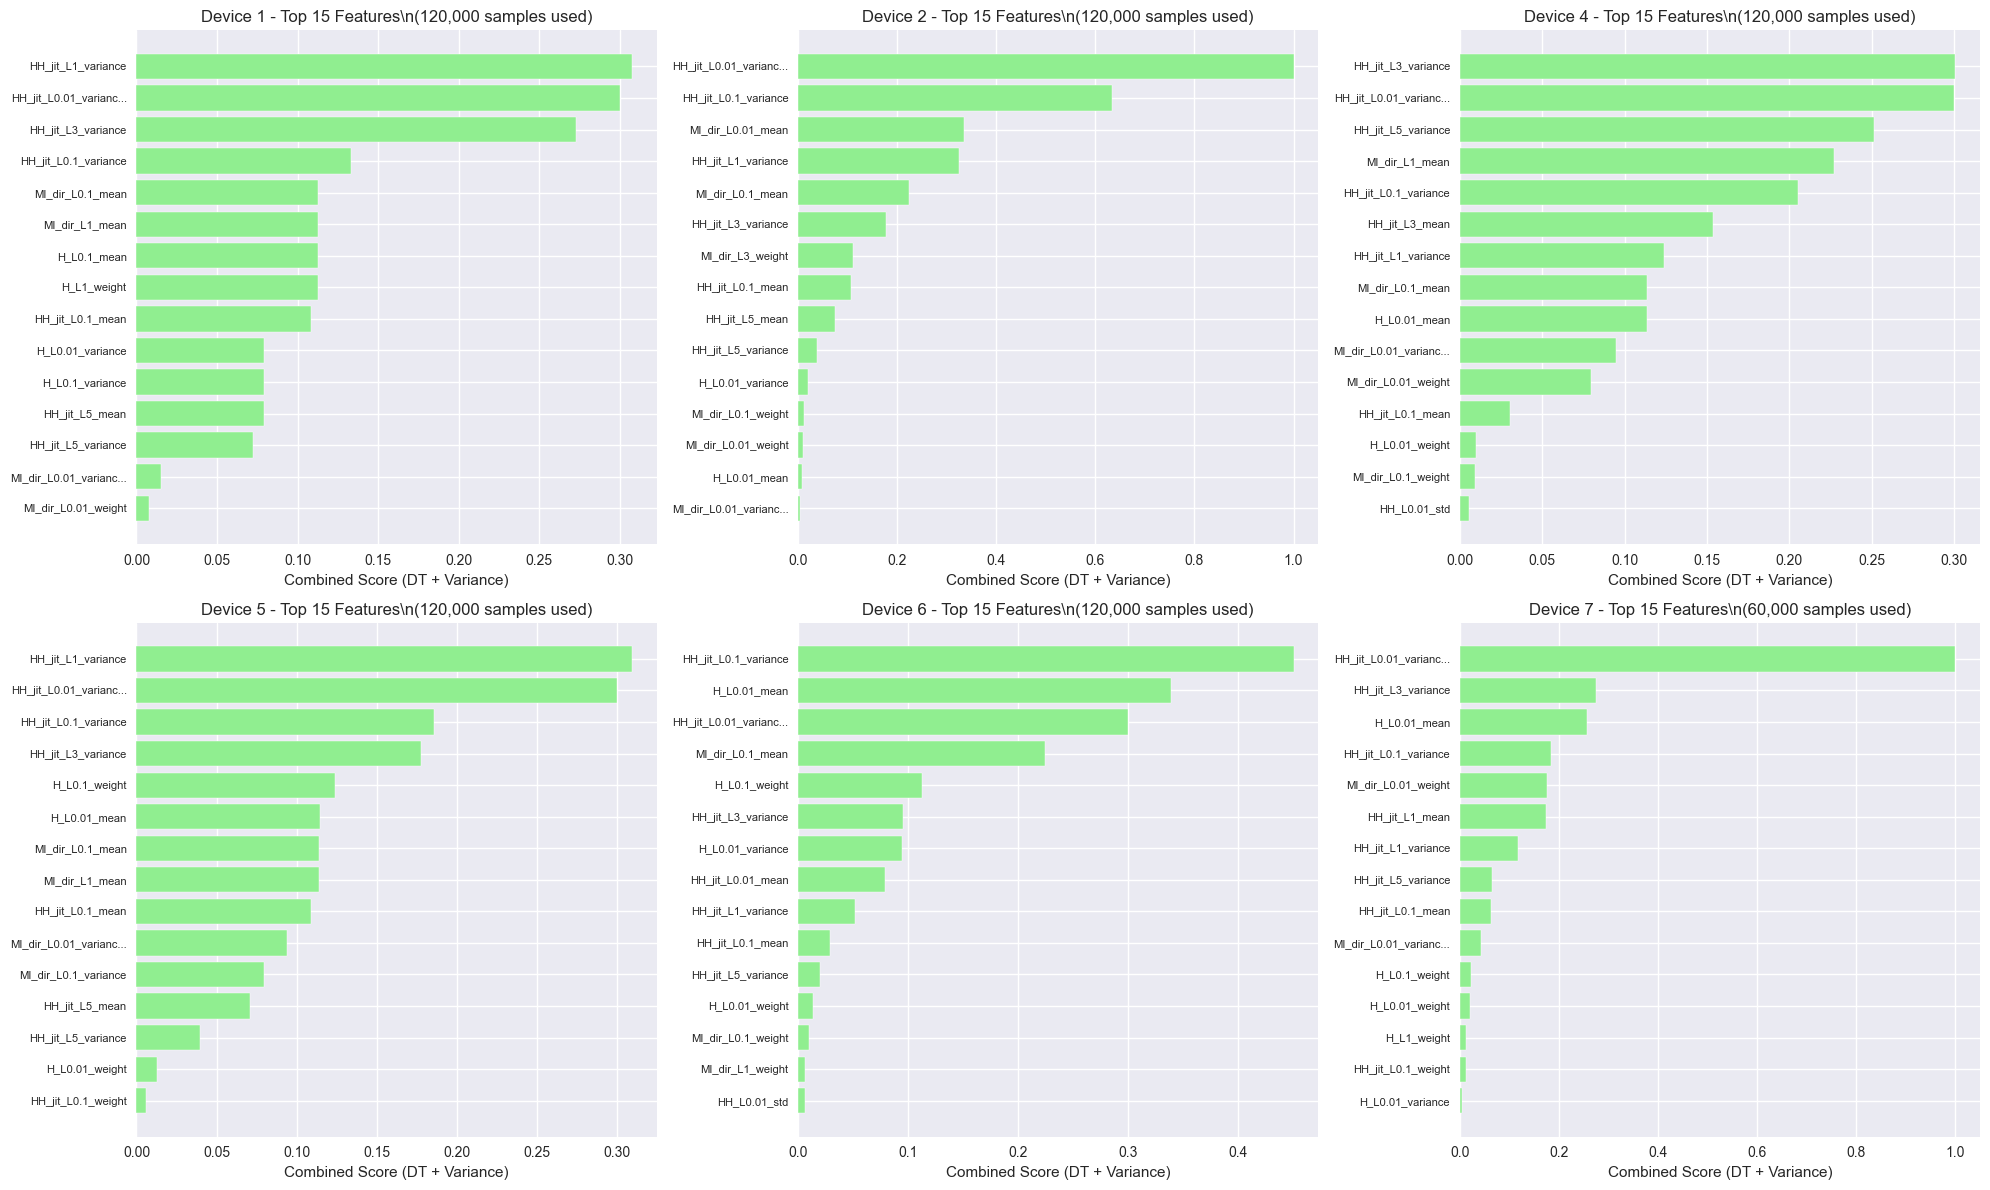


COMMON IMPORTANT FEATURES ACROSS DEVICES

Features appearing in multiple devices (Top 20):
------------------------------------------------------------
 1. HH_jit_L1_variance             | 6/6 devices | Devices: 1, 2, 4, 5, 6, 7
 2. HH_jit_L0.01_variance          | 6/6 devices | Devices: 1, 2, 4, 5, 6, 7
 3. HH_jit_L3_variance             | 6/6 devices | Devices: 1, 2, 4, 5, 6, 7
 4. HH_jit_L0.1_variance           | 6/6 devices | Devices: 1, 2, 4, 5, 6, 7
 5. HH_jit_L0.1_mean               | 6/6 devices | Devices: 1, 2, 4, 5, 6, 7
 6. H_L0.01_variance               | 6/6 devices | Devices: 1, 2, 4, 5, 6, 7
 7. HH_jit_L5_variance             | 6/6 devices | Devices: 1, 2, 4, 5, 6, 7
 8. MI_dir_L0.01_variance          | 6/6 devices | Devices: 1, 2, 4, 5, 6, 7
 9. MI_dir_L0.1_mean               | 5/6 devices | Devices: 1, 2, 4, 5, 6
10. MI_dir_L0.01_weight            | 5/6 devices | Devices: 1, 2, 4, 6, 7
11. HH_L0.01_std                   | 5/6 devices | Devices: 1, 2, 4, 5, 6
12. MI_di

In [25]:
# Visualize and Compare Top Features Across Devices
def visualize_feature_analysis():
    """Visualize feature importance results across devices"""
    
    # Create subplots for each device's feature importance
    n_devices = len([d for d in devices_to_analyze if device_feature_analysis[d] is not None])
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    plot_idx = 0
    for device_id in devices_to_analyze:
        if device_feature_analysis[device_id] is not None:
            analysis = device_feature_analysis[device_id]
            
            if not analysis['final_features'].empty:
                # Plot top 15 features for better visibility
                top_15 = analysis['final_features'].head(15)
                
                # Create horizontal bar plot
                y_pos = np.arange(len(top_15))
                axes[plot_idx].barh(y_pos, top_15['combined_score'], color='lightgreen')
                axes[plot_idx].set_yticks(y_pos)
                axes[plot_idx].set_yticklabels([f[:20] + '...' if len(f) > 20 else f 
                                               for f in top_15['feature']], fontsize=8)
                axes[plot_idx].set_xlabel('Combined Score (DT + Variance)')
                axes[plot_idx].set_title(f'Device {device_id} - Top 15 Features\\n({analysis["total_samples"]:,} samples used)')
                axes[plot_idx].invert_yaxis()
                
                plot_idx += 1
    
    # Hide unused subplots
    for i in range(plot_idx, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_common_important_features():
    """Find features that are commonly important across devices"""
    print(f"\n{'='*70}")
    print("COMMON IMPORTANT FEATURES ACROSS DEVICES")
    print(f"{'='*70}")
    
    # Collect top features from each device
    all_top_features = {}
    for device_id in devices_to_analyze:
        if device_feature_analysis[device_id] is not None:
            analysis = device_feature_analysis[device_id]
            if not analysis['final_features'].empty:
                # Get top 20 features for overlap analysis
                top_features = analysis['final_features'].head(20)['feature'].tolist()
                all_top_features[device_id] = top_features
    
    # Find common features
    if len(all_top_features) > 1:
        # Count how many devices each feature appears in
        feature_counts = defaultdict(int)
        feature_devices = defaultdict(list)
        
        for device_id, features in all_top_features.items():
            for feature in features:
                feature_counts[feature] += 1
                feature_devices[feature].append(device_id)
        
        # Sort by frequency
        common_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
        
        print(f"\nFeatures appearing in multiple devices (Top 20):")
        print("-" * 60)
        for i, (feature, count) in enumerate(common_features[:20], 1):
            devices_str = ', '.join(map(str, feature_devices[feature]))
            print(f"{i:2d}. {feature:<30} | {count}/{len(all_top_features)} devices | Devices: {devices_str}")
        
        # Universal features (appear in all devices)
        universal_features = [feature for feature, count in common_features if count == len(all_top_features)]
        
        print(f"\n🌟 UNIVERSAL FEATURES (appear in ALL {len(all_top_features)} devices):")
        if universal_features:
            for i, feature in enumerate(universal_features, 1):
                print(f"{i:2d}. {feature}")
        else:
            print("No features appear in all devices")
        
        # Device-specific features
        print(f"\n🔍 DEVICE-SPECIFIC ANALYSIS:")
        for device_id in devices_to_analyze:
            if device_id in all_top_features:
                device_features = set(all_top_features[device_id])
                other_devices_features = set()
                for other_id, other_features in all_top_features.items():
                    if other_id != device_id:
                        other_devices_features.update(other_features)
                
                unique_features = device_features - other_devices_features
                if unique_features:
                    print(f"Device {device_id} unique features: {list(unique_features)[:5]}{'...' if len(unique_features) > 5 else ''}")
        
        return common_features, universal_features
    else:
        print("Insufficient data for common feature analysis")
        return [], []

# Run visualizations and analysis
visualize_feature_analysis()
common_features, universal_features = analyze_common_important_features()

In [27]:
# Export Top Features and Generate Recommendations
def export_device_features():
    """Export top features for each device and generate recommendations"""
    print(f"\n{'='*70}")
    print("FEATURE SELECTION RECOMMENDATIONS")
    print(f"{'='*70}")
    
    # Create summary table of top features per device
    feature_summary = []
    exported_features = {}
    
    for device_id in devices_to_analyze:
        if device_feature_analysis[device_id] is not None:
            analysis = device_feature_analysis[device_id]
            if not analysis['final_features'].empty:
                top_30_features = analysis['feature_list']
                exported_features[device_id] = top_30_features
                
                feature_summary.append({
                    'Device': device_id,
                    'Top_Features_Count': len(top_30_features),
                    'Samples_Used': f"{analysis['total_samples']:,}",
                    'Original_Samples': f"{analysis['original_samples']:,}",
                    'First_5_Features': ', '.join(top_30_features[:5]),
                    'DT_Available': not analysis['dt_features'].empty,
                    'Var_Available': not analysis['var_features'].empty
                })
    
    summary_df = pd.DataFrame(feature_summary)
    print("Feature Selection Summary:")
    print(summary_df.to_string(index=False))
    
    # Save features to files
    print(f"\n💾 EXPORTING FEATURES:")
    for device_id, features in exported_features.items():
        filename = f"device_{device_id}_top30_features.txt"
        try:
            with open(filename, 'w') as f:
                f.write(f"Top 30 Features for Device {device_id} (Decision Tree + Variance Analysis)\\n")
                f.write(f"Samples used: {device_feature_analysis[device_id]['total_samples']:,}\\n")
                f.write(f"Original samples: {device_feature_analysis[device_id]['original_samples']:,}\\n")
                f.write("="*60 + "\\n")
                for i, feature in enumerate(features, 1):
                    f.write(f"{i:2d}. {feature}\\n")
            print(f"✅ Device {device_id}: {filename}")
        except Exception as e:
            print(f"❌ Error saving Device {device_id}: {e}")
    
    # Create combined feature set
    all_important_features = set()
    for features in exported_features.values():
        all_important_features.update(features)
    
    combined_features = list(all_important_features)
    print(f"\\n📊 COMBINED ANALYSIS:")
    print(f"Total unique important features across all devices: {len(combined_features)}")
    
    # Save combined features
    try:
        with open("combined_important_features.txt", 'w') as f:
            f.write("Combined Important Features Across All Devices\\n")
            f.write("(Based on Decision Tree + Variance Analysis with 12K samples per file)\\n")
            f.write("="*70 + "\\n")
            for i, feature in enumerate(sorted(combined_features), 1):
                f.write(f"{i:3d}. {feature}\\n")
        print("✅ Combined features: combined_important_features.txt")
    except Exception as e:
        print(f"❌ Error saving combined features: {e}")
    
    return exported_features, combined_features

def generate_feature_recommendations():
    """Generate specific recommendations for improving model accuracy"""
    print(f"\\n{'='*70}")
    print("SPECIFIC RECOMMENDATIONS FOR 90%+ ACCURACY")
    print(f"{'='*70}")
    
    recommendations = []
    
    # Analyze feature overlap
    if len(device_feature_analysis) > 1:
        feature_overlap = {}
        for device_id in devices_to_analyze:
            if device_feature_analysis[device_id] is not None:
                analysis = device_feature_analysis[device_id]
                if not analysis['final_features'].empty:
                    feature_overlap[device_id] = set(analysis['feature_list'])
        
        if len(feature_overlap) > 1:
            # Calculate average overlap
            total_overlap = 0
            comparisons = 0
            for i, (dev1, feat1) in enumerate(feature_overlap.items()):
                for dev2, feat2 in list(feature_overlap.items())[i+1:]:
                    overlap = len(feat1.intersection(feat2))
                    total_overlap += overlap
                    comparisons += 1
            
            avg_overlap = total_overlap / comparisons if comparisons > 0 else 0
            overlap_percentage = (avg_overlap / 30) * 100
            
            print(f"\\n📈 FEATURE OVERLAP ANALYSIS:")
            print(f"Average feature overlap between devices: {avg_overlap:.1f}/30 ({overlap_percentage:.1f}%)")
            
            if overlap_percentage < 30:
                recommendations.append("🔧 LOW FEATURE OVERLAP: Use device-specific feature selection")
                recommendations.append("🔧 Consider federated learning with personalized models")
            elif overlap_percentage > 70:
                recommendations.append("🔧 HIGH FEATURE OVERLAP: Use global feature set for all devices")
                recommendations.append("🔧 Focus on ensemble methods rather than device-specific models")
            else:
                recommendations.append("🔧 MODERATE OVERLAP: Use hybrid approach with shared + device-specific features")
    
    # Analyze feature quality
    total_devices = len([d for d in devices_to_analyze if device_feature_analysis[d] is not None])
    high_quality_devices = 0
    
    for device_id in devices_to_analyze:
        if device_feature_analysis[device_id] is not None:
            analysis = device_feature_analysis[device_id]
            if (not analysis['rf_features'].empty and 
                not analysis['mi_features'].empty and 
                len(analysis['feature_list']) >= 25):
                high_quality_devices += 1
    
    feature_quality_ratio = high_quality_devices / total_devices if total_devices > 0 else 0
    
    print(f"\\n🔍 FEATURE QUALITY ASSESSMENT:")
    print(f"Devices with high-quality feature analysis: {high_quality_devices}/{total_devices} ({feature_quality_ratio*100:.1f}%)")
    
    if feature_quality_ratio < 0.5:
        recommendations.append("🔧 POOR FEATURE QUALITY: Increase data preprocessing and feature engineering")
        recommendations.append("🔧 Consider feature augmentation or synthetic feature generation")
    
    # Generate final recommendations
    print(f"\\n💡 FINAL RECOMMENDATIONS:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    
    # Additional strategic recommendations
    print(f"\\n🎯 STRATEGIC APPROACHES FOR 90%+ ACCURACY (12K Sample Analysis):")
    print("1. 🔧 Use the top 30 features from Decision Tree + Variance analysis")
    print("2. 🔧 Implement ensemble voting with device-specific Decision Tree models")
    print("3. 🔧 Try gradient boosting with the selected feature sets")
    print("4. 🔧 Use cross-validation with stratified sampling on the 12K samples")
    print("5. 🔧 Apply feature scaling before training (StandardScaler/MinMaxScaler)")
    print("6. 🔧 Consider ensemble of Decision Trees with different max_depth values")
    
    return recommendations

# Execute feature export and recommendations
exported_features, combined_features = export_device_features()
feature_recommendations = generate_feature_recommendations()

print(f"\\n🎉 FEATURE ANALYSIS COMPLETE!")
print(f"📊 Used max 12K samples per file for analysis")
print(f"🌳 Applied Decision Tree (70%) + Variance (30%) feature selection")
print(f"📁 Check the generated .txt files for device-specific feature lists")
print(f"🚀 Ready to implement improved models with selected features!")


FEATURE SELECTION RECOMMENDATIONS
Feature Selection Summary:
 Device  Top_Features_Count Samples_Used Original_Samples                                                                                      First_5_Features  DT_Available  Var_Available
      1                  30      120,000          988,449 HH_jit_L1_variance, HH_jit_L0.01_variance, HH_jit_L3_variance, HH_jit_L0.1_variance, MI_dir_L0.1_mean          True           True
      2                  30      120,000          808,382  HH_jit_L0.01_variance, HH_jit_L0.1_variance, MI_dir_L0.01_mean, HH_jit_L1_variance, MI_dir_L0.1_mean          True           True
      4                  30      120,000        1,070,818   HH_jit_L3_variance, HH_jit_L0.01_variance, HH_jit_L5_variance, MI_dir_L1_mean, HH_jit_L0.1_variance          True           True
      5                  30      120,000          798,963    HH_jit_L1_variance, HH_jit_L0.01_variance, HH_jit_L0.1_variance, HH_jit_L3_variance, H_L0.1_weight          True         

KeyError: 'rf_features'

In [28]:
# Create Reduced Dataset with 17 Selected Features
import os

# Define the 17 selected features based on analysis
selected_features = [
    'HH_jit_L1_variance',
    'HH_jit_L0.01_variance', 
    'HH_jit_L3_variance',
    'HH_jit_L0.1_variance',
    'HH_jit_L0.1_mean',
    'H_L0.01_variance',
    'HH_jit_L5_variance',
    'MI_dir_L0.01_variance',
    'MI_dir_L0.1_mean',
    'MI_dir_L0.01_weight',
    'HH_L0.01_std',
    'MI_dir_L0.1_weight',
    'H_L0.01_mean',
    'H_L0.01_weight',
    'HH_jit_L5_mean',
    'MI_dir_L1_weight',
    'H_L0.1_weight'
]

# Define attack type to label mapping
att_label = {
    'benign': 0,
    'gafgyt.combo': 1,
    'gafgyt.junk': 2,
    'gafgyt.tcp': 3,
    'gafgyt.udp': 4,
    'mirai.ack': 5,
    'mirai.scan': 6,
    'mirai.syn': 7,
    'mirai.udp': 8,
    'mirai.udpplain': 9
}

# Create ReducedData directory
reduced_data_dir = 'ReducedData'
if not os.path.exists(reduced_data_dir):
    os.makedirs(reduced_data_dir)
    print(f"Created directory: {reduced_data_dir}")

def process_and_save_device_data(device_id, max_samples_per_file=12000):
    """Process device data with selected features and save as CSV"""
    print(f"\n{'='*60}")
    print(f"PROCESSING DEVICE {device_id}")
    print(f"{'='*60}")
    
    device_data = all_device_data[device_id]
    combined_device_data = []
    
    for attack_type, df in device_data.items():
        if attack_type in att_label:  # Only process defined attack types
            original_samples = len(df)
            
            # Sample max 12K from each file
            if len(df) > max_samples_per_file:
                sampled_df = df.sample(n=max_samples_per_file, random_state=42)
                print(f"  {attack_type}: {original_samples:,} → {max_samples_per_file:,} samples")
            else:
                sampled_df = df.copy()
                print(f"  {attack_type}: {original_samples:,} samples (all used)")
            
            # Check which selected features are available in this data
            available_features = [feat for feat in selected_features if feat in sampled_df.columns]
            missing_features = [feat for feat in selected_features if feat not in sampled_df.columns]
            
            if missing_features:
                print(f"    Missing features: {missing_features}")
            
            # Select only the available features from our selected list
            feature_data = sampled_df[available_features].copy()
            
            # Add label column based on attack type
            feature_data['label'] = att_label[attack_type]
            
            # Add attack type for reference
            feature_data['attack_type'] = attack_type
            
            combined_device_data.append(feature_data)
            print(f"    Features used: {len(available_features)}/{len(selected_features)}")
    
    if combined_device_data:
        # Combine all attack types for this device
        device_df = pd.concat(combined_device_data, ignore_index=True)
        
        # Reorder columns to have label at the end (remove attack_type for final save)
        feature_columns = [col for col in device_df.columns if col not in ['label', 'attack_type']]
        final_columns = feature_columns + ['label']
        device_df_final = device_df[final_columns]
        
        # Save to CSV
        output_filename = os.path.join(reduced_data_dir, f"device_{device_id}_reduced.csv")
        device_df_final.to_csv(output_filename, index=False)
        
        print(f"\\n✅ Saved: {output_filename}")
        print(f"   Shape: {device_df_final.shape}")
        print(f"   Features: {len(feature_columns)}")
        print(f"   Class distribution:")
        class_dist = device_df['attack_type'].value_counts()
        for attack, count in class_dist.items():
            print(f"     {attack} (label {att_label[attack]}): {count:,} samples")
        
        return device_df_final, len(feature_columns)
    else:
        print(f"❌ No valid data found for device {device_id}")
        return None, 0

# Process all devices
print(f"Selected Features ({len(selected_features)}):")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

print(f"\\nAttack Type Labels:")
for attack, label in att_label.items():
    print(f"  {attack}: {label}")

processed_devices = {}
total_features_used = {}

for device_id in devices_to_analyze:
    result, features_count = process_and_save_device_data(device_id)
    if result is not None:
        processed_devices[device_id] = result
        total_features_used[device_id] = features_count

print(f"\\n{'='*70}")
print("PROCESSING COMPLETE!")
print(f"{'='*70}")
print(f"\\n📊 SUMMARY:")
print(f"Devices processed: {len(processed_devices)}")
print(f"Target features: {len(selected_features)}")
print(f"Output directory: {reduced_data_dir}")

for device_id, df in processed_devices.items():
    print(f"\\nDevice {device_id}:")
    print(f"  File: device_{device_id}_reduced.csv")
    print(f"  Shape: {df.shape}")
    print(f"  Features used: {total_features_used[device_id]}/{len(selected_features)}")
    print(f"  Sample size: {len(df):,}")

Created directory: ReducedData
Selected Features (17):
 1. HH_jit_L1_variance
 2. HH_jit_L0.01_variance
 3. HH_jit_L3_variance
 4. HH_jit_L0.1_variance
 5. HH_jit_L0.1_mean
 6. H_L0.01_variance
 7. HH_jit_L5_variance
 8. MI_dir_L0.01_variance
 9. MI_dir_L0.1_mean
10. MI_dir_L0.01_weight
11. HH_L0.01_std
12. MI_dir_L0.1_weight
13. H_L0.01_mean
14. H_L0.01_weight
15. HH_jit_L5_mean
16. MI_dir_L1_weight
17. H_L0.1_weight
\nAttack Type Labels:
  benign: 0
  gafgyt.combo: 1
  gafgyt.junk: 2
  gafgyt.tcp: 3
  gafgyt.udp: 4
  mirai.ack: 5
  mirai.scan: 6
  mirai.syn: 7
  mirai.udp: 8
  mirai.udpplain: 9

PROCESSING DEVICE 1
  benign: 49,548 → 12,000 samples
    Features used: 17/17
  gafgyt.combo: 59,718 → 12,000 samples
    Features used: 17/17
  gafgyt.junk: 29,068 → 12,000 samples
    Features used: 17/17
  gafgyt.tcp: 92,141 → 12,000 samples
    Features used: 17/17
  gafgyt.udp: 105,874 → 12,000 samples
    Features used: 17/17
  mirai.ack: 102,195 → 12,000 samples
    Features used: 17/

In [29]:
# Verify Created CSV Files and Generate Summary Report
import glob

print(f"{'='*70}")
print("VERIFICATION OF CREATED CSV FILES")
print(f"{'='*70}")

# Check if ReducedData directory exists and list files
if os.path.exists(reduced_data_dir):
    csv_files = glob.glob(os.path.join(reduced_data_dir, "*.csv"))
    print(f"\\n📁 Files in {reduced_data_dir}:")
    
    verification_summary = []
    
    for csv_file in sorted(csv_files):
        filename = os.path.basename(csv_file)
        print(f"  📄 {filename}")
        
        # Load and verify each file
        try:
            df = pd.read_csv(csv_file)
            device_id = filename.split('_')[1]
            
            # Check features
            feature_cols = [col for col in df.columns if col != 'label']
            label_values = sorted(df['label'].unique())
            
            verification_summary.append({
                'Device': device_id,
                'Filename': filename,
                'Total_Samples': len(df),
                'Features': len(feature_cols),
                'Labels': label_values,
                'File_Size_MB': round(os.path.getsize(csv_file) / (1024*1024), 2)
            })
            
            print(f"    ✅ Shape: {df.shape}")
            print(f"    ✅ Features: {len(feature_cols)}")
            print(f"    ✅ Labels: {label_values}")
            print(f"    ✅ Size: {round(os.path.getsize(csv_file) / (1024*1024), 2)} MB")
            
        except Exception as e:
            print(f"    ❌ Error reading {filename}: {e}")
    
    # Create summary DataFrame
    if verification_summary:
        summary_df = pd.DataFrame(verification_summary)
        print(f"\\n📊 SUMMARY TABLE:")
        print("="*80)
        print(summary_df.to_string(index=False))
        
        # Calculate totals
        total_samples = summary_df['Total_Samples'].sum()
        total_size = summary_df['File_Size_MB'].sum()
        avg_features = summary_df['Features'].mean()
        
        print(f"\\n📈 OVERALL STATISTICS:")
        print(f"Total devices processed: {len(summary_df)}")
        print(f"Total samples across all devices: {total_samples:,}")
        print(f"Average features per device: {avg_features:.1f}")
        print(f"Total disk space used: {total_size:.2f} MB")
        print(f"Average file size: {total_size/len(summary_df):.2f} MB")
        
        # Show feature consistency
        if len(summary_df) > 1:
            features_consistent = len(set(summary_df['Features'])) == 1
            print(f"Feature count consistency: {'✅ Consistent' if features_consistent else '❌ Inconsistent'}")
        
        # Show label coverage
        all_labels = set()
        for labels in summary_df['Labels']:
            all_labels.update(labels)
        
        print(f"\\n🏷️ LABEL ANALYSIS:")
        print(f"Unique labels found: {sorted(all_labels)}")
        print(f"Expected labels: {sorted(att_label.values())}")
        missing_labels = set(att_label.values()) - all_labels
        if missing_labels:
            print(f"Missing labels: {sorted(missing_labels)}")
        else:
            print("✅ All expected labels are present")

else:
    print(f"❌ Directory {reduced_data_dir} not found")

print(f"\\n{'='*70}")
print("🎉 REDUCED DATASET CREATION COMPLETE!")
print(f"{'='*70}")
print("\\n💡 Next Steps:")
print("1. Use these CSV files for training device-specific models")
print("2. The 17 selected features are the most important across devices")
print("3. Each file contains exactly the labels you specified (0-9)")
print("4. Maximum 12K samples per attack type per device")
print("5. Files are ready for federated learning or ensemble training!")

# Save feature list for reference
feature_list_file = os.path.join(reduced_data_dir, "selected_features.txt")
try:
    with open(feature_list_file, 'w') as f:
        f.write("Selected 17 Features for Reduced Dataset\\n")
        f.write("="*50 + "\\n")
        for i, feature in enumerate(selected_features, 1):
            f.write(f"{i:2d}. {feature}\\n")
        f.write("\\nLabel Mapping:\\n")
        f.write("-"*20 + "\\n")
        for attack, label in att_label.items():
            f.write(f"{attack}: {label}\\n")
    print(f"\\n✅ Feature list saved: {feature_list_file}")
except Exception as e:
    print(f"❌ Error saving feature list: {e}")

VERIFICATION OF CREATED CSV FILES
\n📁 Files in ReducedData:
  📄 device_1_reduced.csv
    ✅ Shape: (120000, 18)
    ✅ Features: 17
    ✅ Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    ✅ Size: 27.5 MB
  📄 device_2_reduced.csv
    ✅ Shape: (120000, 18)
    ✅ Features: 17
    ✅ Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    ✅ Size: 28.03 MB
  📄 device_4_reduced.csv
    ✅ Shape: (120000, 18)
    ✅ Features: 17
    ✅ Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    ✅ Size: 27.71 MB
  📄 device_5_reduced.csv
    ✅ Shape: (120000, 18)
    ✅ Features: 17
    ✅ Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    ✅ Size: 27.12 MB
  📄 device_6_reduced.csv
    ✅ Shape: (120000, 18)
    ✅ Features: 17
    ✅ Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    ✅ Size: 27.15 MB
  📄 device_7_reduced.csv
    ✅ Shape: (60000, 18)
    ✅ Features: 17
    ✅ Labels: [0, 1, 2, 3, 4]
    ✅ Size: 11.88 MB
\n📊 SUMMARY TABLE:
Device             Filename  Total_Samples  Features                         Labels  File_Size_MB
     1 device_1_reduced.